# Experiment 1


**Aim:**To implement an image classification model using convolutional neural networks (CNNs) for recognizing objects in images, incorporating data augmentation techniques to improve model generalization.

**Theory:**

Convolutional Neural Networks (CNNs) are a class of deep learning models widely used for image classification tasks. They work by automatically detecting patterns and features from images, such as edges and textures, through convolutional layers, without requiring manual feature extraction. In this experiment, a CNN is designed to classify images into two categories: cats and dogs. Data augmentation techniques, including random flipping, rotation, and translation, are applied to enhance model generalization and prevent overfitting by increasing the diversity of the training set.

The CNN architecture begins with convolutional layers, followed by max-pooling to reduce spatial dimensions while preserving important features. Batch normalization is used to stabilize and speed up the training process, while dropout layers prevent overfitting by randomly turning off neurons during training. The model is trained using binary cross-entropy as the loss function and Adam optimizer, a widely used algorithm for efficient gradient-based optimization.

By applying these methods, the model aims to achieve high accuracy in classifying the test images, while robustly handling variations in data and improving generalization performance.

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-07-11 05:13:57.956587: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 05:13:57.956648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 05:13:57.958158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 05:13:57.966115: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
image_size = (256,256)
batch_size = 32
img_h = 256
img_w = 256

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/workspace/ADNN/Exp-1/Data/training_set/training_set",
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=batch_size,
    image_size = image_size,
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Using 1601 files for validation.


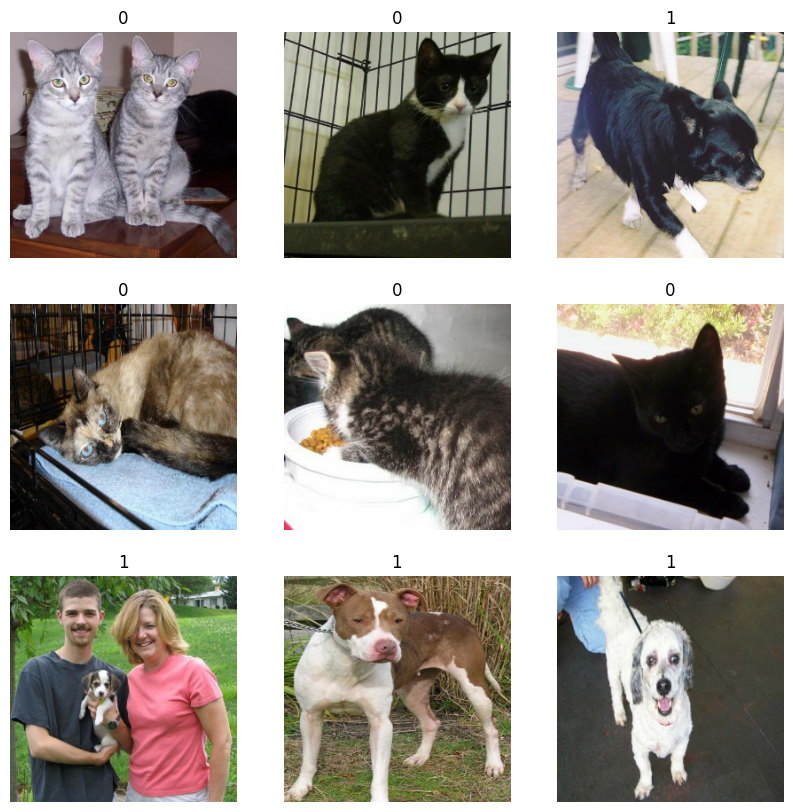

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation((-0.2, 0.3),(-0.2, 0.3)),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
#parallel mapping
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 resizing_4 (Resizing)       (None, 256, 256, 3)          0         ['input_5[0][0]']             
                                                                                                  
 random_flip_7 (RandomFlip)  (None, 256, 256, 3)          0         ['resizing_4[0][0]']          
                                                                                                  
 random_rotation_7 (RandomR  (None, 256, 256, 3)          0         ['random_flip_7[0][0]']       
 otation)                                                                                   

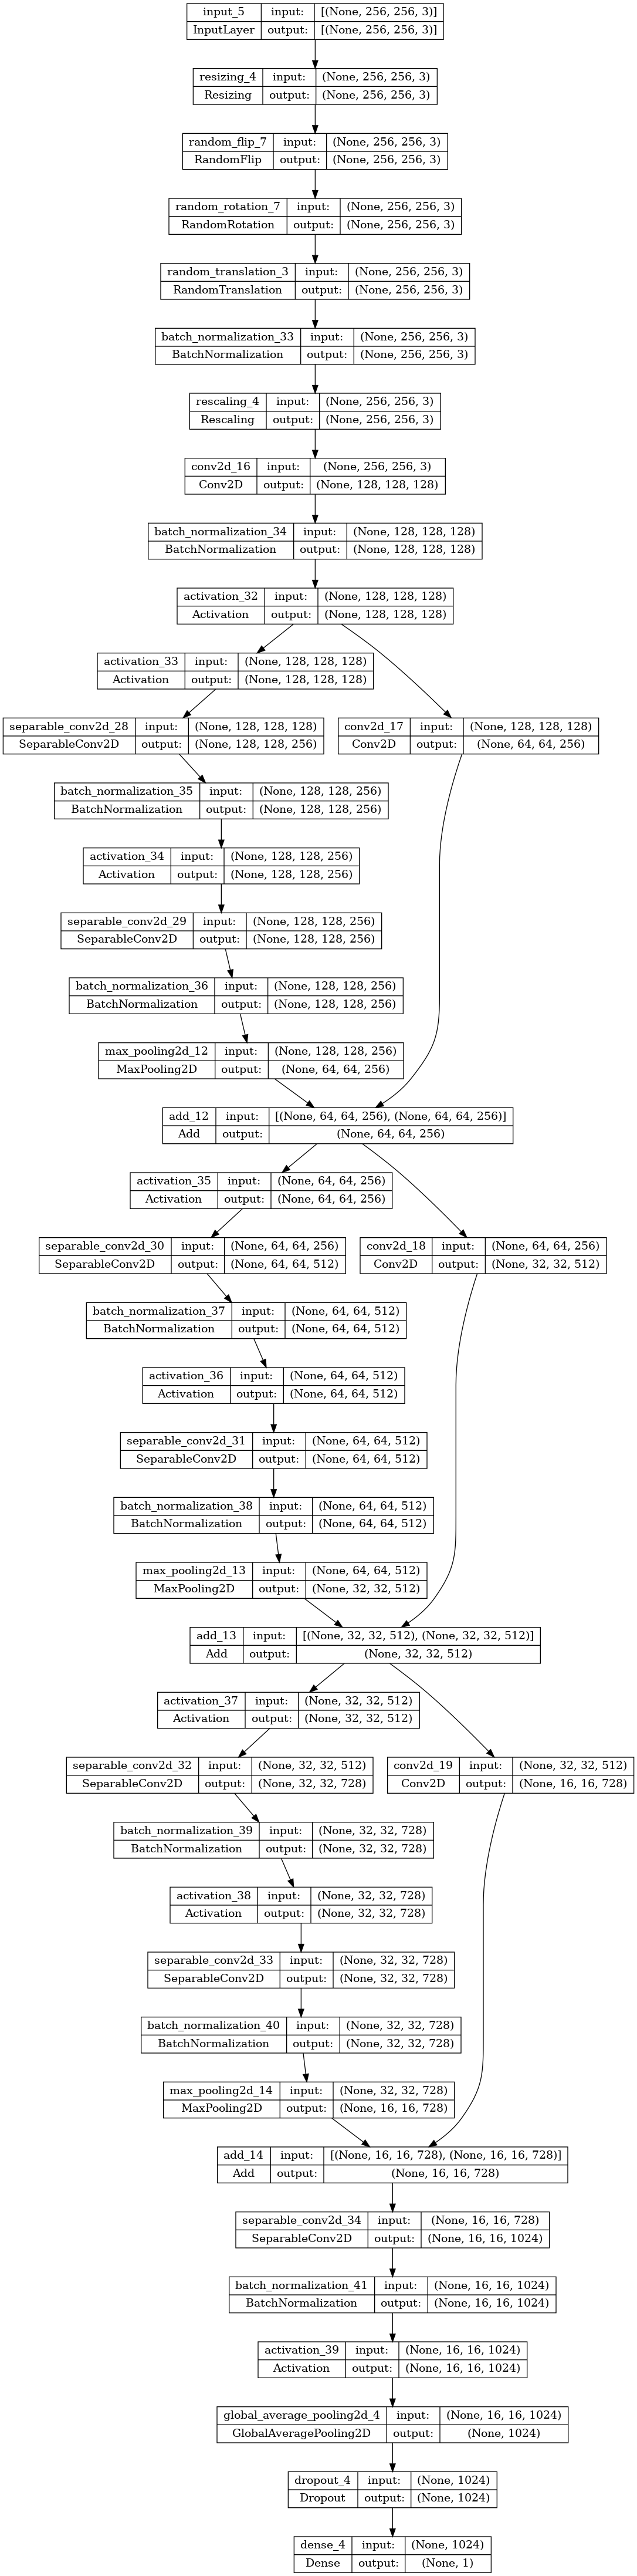

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Resizing(img_h, img_w)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.01)(x)
    x = layers.RandomTranslation((-0.2, 0.3),(-0.2, 0.3))(x)
    x = layers.BatchNormalization()(x)
    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         units = 1
#     else:
#         units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(256,256) + (3,), num_classes=2)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 230400)           

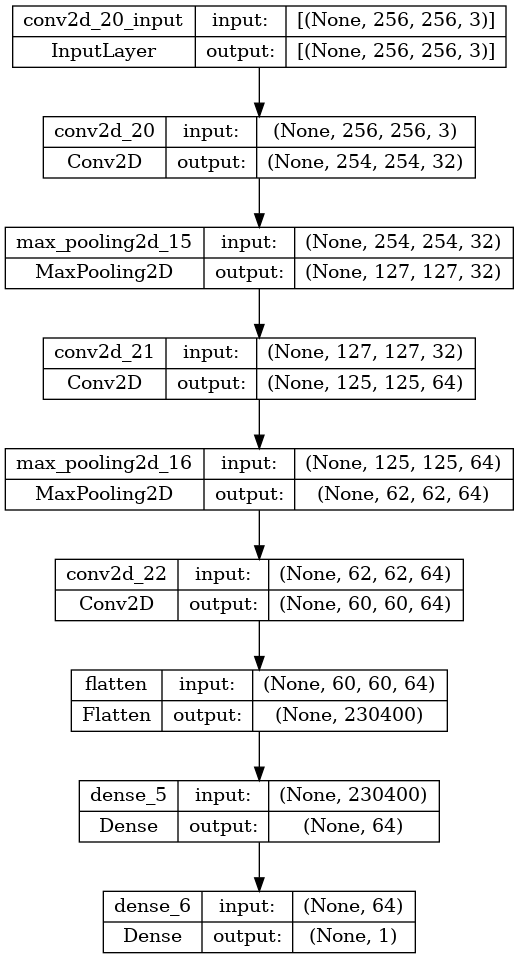

In [ ]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf
import matplotlib.pyplot as plt

def make_simple_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    if num_classes == 2:
        model.add(layers.Dense(1, activation='sigmoid'))
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Specify input shape and number of classes
input_shape = (256, 256, 3)
num_classes = 2  # Update this to your number of classes

model = make_simple_model(input_shape, num_classes)
model.summary()

# Plot model architecture
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
#     callbacks=callbacks,""
    validation_data=val_ds,
)

Epoch 1/10
201/201 [==============================] - 13s 38ms/step - loss: 11.7637 - acc: 0.5314 - val_loss: 0.6909 - val_acc: 0.5728
Epoch 2/10
201/201 [==============================] - 6s 30ms/step - loss: 0.6878 - acc: 0.5531 - val_loss: 0.6967 - val_acc: 0.5315
Epoch 3/10
201/201 [==============================] - 6s 29ms/step - loss: 0.6880 - acc: 0.5428 - val_loss: 0.6900 - val_acc: 0.5778
Epoch 4/10
201/201 [==============================] - 6s 29ms/step - loss: 0.6899 - acc: 0.5515 - val_loss: 0.6875 - val_acc: 0.5709
Epoch 5/10
201/201 [==============================] - 6s 29ms/step - loss: 0.6886 - acc: 0.5434 - val_loss: 0.6838 - val_acc: 0.5659
Epoch 6/10
201/201 [==============================] - 6s 29ms/step - loss: 0.6862 - acc: 0.5504 - val_loss: 0.6969 - val_acc: 0.5209
Epoch 7/10
201/201 [==============================] - 6s 30ms/step - loss: 0.6879 - acc: 0.5493 - val_loss: 0.6921 - val_acc: 0.5378
Epoch 8/10
201/201 [==============================] - 6s 29ms/step 

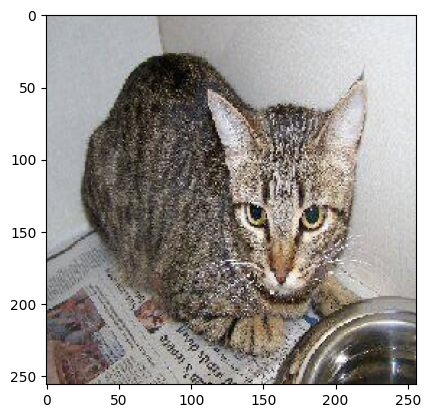

1/1 [==============================] - 0s 84ms/step
This image is 37.72% cat and 62.28% dog.


In [ ]:
import tensorflow as tf
img = keras.utils.load_img("/workspace/ADNN/Exp-1/Data/test_set/test_set/cats/cat.5000.jpg", target_size=(256, 256))
plt.imshow(img)
plt.show()

# Convert the image to an array and preprocess it
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch axis

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0][0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

In [ ]:
from tensorflow.keras import layers, models, optimizers

def create_model(learn_rate=0.01, momentum=0):
    model = models.Sequential([
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
learn_rate = [1e-9, 1e-3]
momentum = [0.6, 0.9]

def try_fit(learn_rate, momentum, epochs=30):
    history_page = []
    for lr in learn_rate:
        for moment in momentum:
            model = create_model(lr, moment)
            history = model.fit(
                train_ds,
                epochs=epochs,
                validation_data=val_ds
            )
            history_page.append(history)
    return history_page

# Assuming train_ds and val_ds are defined datasets
history_page = try_fit(learn_rate, momentum)
print(history_page[0].history['accuracy'])

Epoch 1/30
201/201 [==============================] - 26s 115ms/step - loss: 2.0379 - accuracy: 0.5222 - val_loss: 2.0064 - val_accuracy: 0.5078
Epoch 2/30
201/201 [==============================] - 20s 99ms/step - loss: 2.0650 - accuracy: 0.5053 - val_loss: 1.9843 - val_accuracy: 0.5053
Epoch 3/30
201/201 [==============================] - 21s 100ms/step - loss: 1.9844 - accuracy: 0.5131 - val_loss: 1.9663 - val_accuracy: 0.5078
Epoch 4/30
201/201 [==============================] - 20s 98ms/step - loss: 1.9625 - accuracy: 0.5172 - val_loss: 1.9543 - val_accuracy: 0.5091
Epoch 5/30
201/201 [==============================] - 20s 99ms/step - loss: 1.9224 - accuracy: 0.5242 - val_loss: 1.9424 - val_accuracy: 0.5097
Epoch 6/30
201/201 [==============================] - 20s 96ms/step - loss: 1.9342 - accuracy: 0.5192 - val_loss: 1.9327 - val_accuracy: 0.5109
Epoch 7/30
201/201 [==============================] - 20s 96ms/step - loss: 1.9097 - accuracy: 0.5142 - val_loss: 1.9244 - val_accurac

**Result**: Successfully implemented an image classification model using convolutional neural networks (CNNs) for recognizing objects in images, incorporating data augmentation techniques to improve model generalization.

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#

In [ ]:
#